<a href="https://colab.research.google.com/github/chigvintseva/UniProject-AST/blob/main/ast_last.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Preview:
            timestamp         floor  person_id  location_x  location_y  \
0 2025-06-20 09:38:00  Ground Floor          1          98          31   
1 2025-06-20 09:51:00  Second Floor          2           6          86   
2 2025-06-20 09:28:00  Second Floor          3          15          62   
3 2025-06-20 09:14:00   First Floor          4          89          85   
4 2025-06-20 09:42:00  Ground Floor          5          59          50   

   smoke_level alarm_status  
0         0.19          OFF  
1         0.15          OFF  
2         0.21          OFF  
3         0.25          OFF  
4         0.37          OFF  

Max X: 99 | Max Y: 99


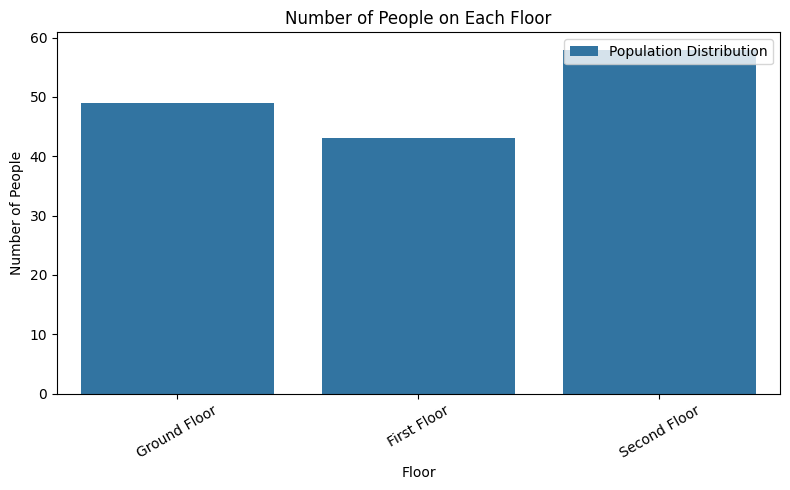

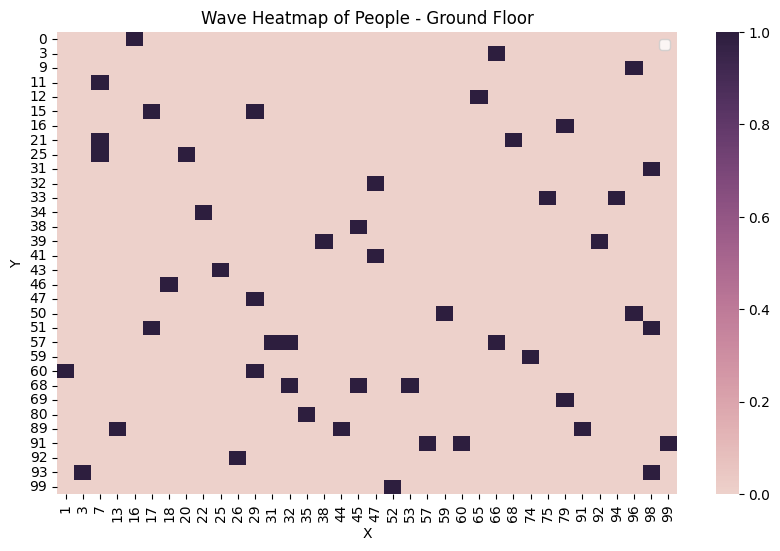

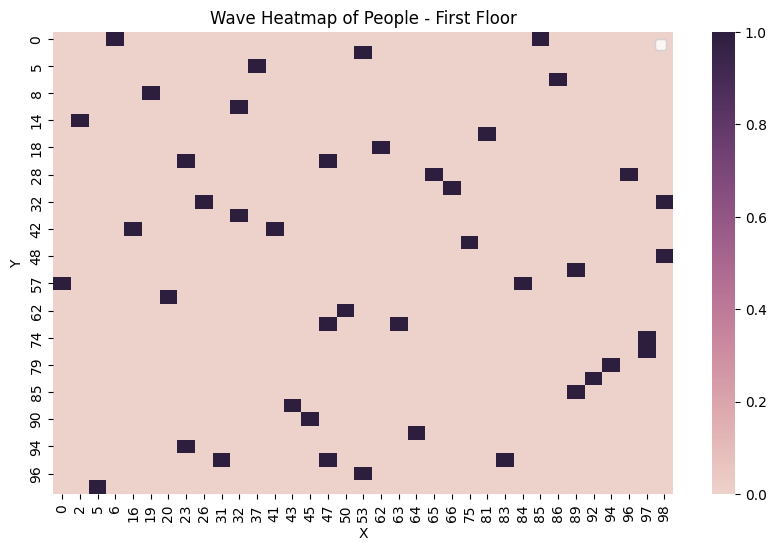

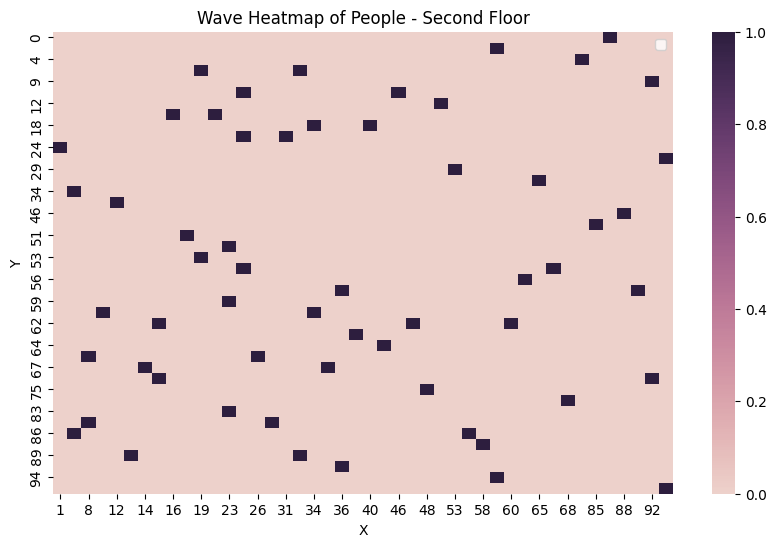

--- ABM Scenario 0: Control ---
Average Evacuation Time: 22.65 sec
Total Evacuation Time: 3397.00 sec
Evacuation Completion Rate: 100.00%

--- ABM Scenario 1: Fire Spread ---
Average Evacuation Time: 35.68 sec
Total Evacuation Time: 5352.00 sec
Evacuation Completion Rate: 98.00%

--- ABM Scenario 2: Crowd Dynamics ---
Average Evacuation Time: 33.93 sec
Total Evacuation Time: 5090.00 sec
Evacuation Completion Rate: 100.00%



/tmp/ipython-input-3-1453949190.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=abm_kpis, x='Scenario', y='Evac Time', palette='Blues')


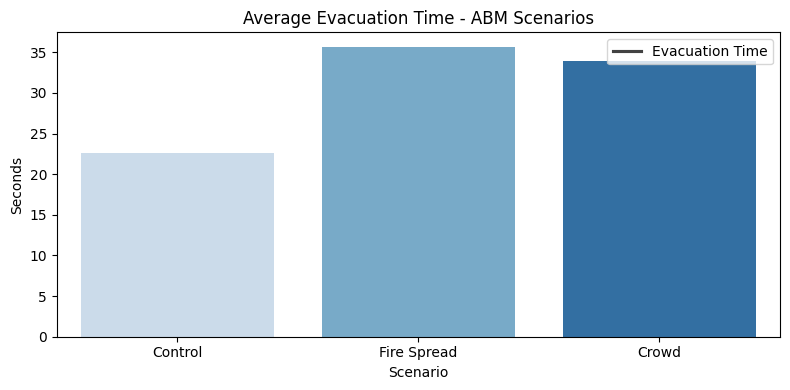

--- DES Scenario 0: Control ---
Average Evacuation Time: 36.45 sec
Total Evacuation Time: 5467.00 sec
Evacuation Completion Rate: 100.00%



/tmp/ipython-input-3-1453949190.py:207: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=des_kpis, x='Scenario', y='Evac Time', palette='Oranges')


--- DES Scenario 1: Delayed Alarm 1F ---
Average Evacuation Time: 41.15 sec
Total Evacuation Time: 6172.00 sec
Evacuation Completion Rate: 100.00%

--- DES Scenario 2: Alarm Failure 2F ---
Average Evacuation Time: 417.33 sec
Total Evacuation Time: 62599.00 sec
Evacuation Completion Rate: 61.33%



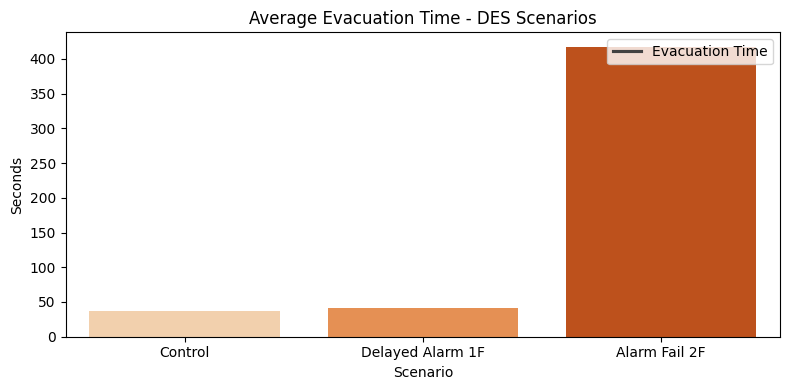

In [3]:
# Jupyter Notebook Style: Smart Building Evacuation Simulation using ABM and DES

# ========================================
# STEP 1: Dataset Generation & Visualization
# ========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

np.random.seed(42)

# Variables
num_people = 150
floors = ['Ground Floor', 'First Floor', 'Second Floor']
timestamps = pd.date_range(start='2025-06-20 09:00:00', periods=60, freq='T')

# Generate synthetic dataset
df = pd.DataFrame({
    'timestamp': np.random.choice(timestamps, num_people),
    'floor': np.random.choice(floors, num_people),
    'person_id': range(1, num_people + 1),
    'location_x': np.random.randint(0, 100, num_people),
    'location_y': np.random.randint(0, 100, num_people),
    'smoke_level': np.round(np.clip(np.random.normal(0.2, 0.1, num_people), 0, 1), 2),
    'alarm_status': np.random.choice(['OFF', 'ON'], num_people, p=[0.9, 0.1])
})

# Head and spatial range
print("Dataset Preview:")
print(df.head())
print("\nMax X:", df['location_x'].max(), "| Max Y:", df['location_y'].max())

# Bar chart - People per floor
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='floor', order=floors)
plt.title("Number of People on Each Floor")
plt.ylabel("Number of People")
plt.xlabel("Floor")
plt.xticks(rotation=30)
plt.legend(['Population Distribution'], loc='upper right')
plt.tight_layout()
plt.show()

# Heatmaps by floor (wave style)
cmap = sns.cubehelix_palette(as_cmap=True)
for floor in floors:
    subset = df[df['floor'] == floor]
    heatmap_data = subset.groupby(['location_y', 'location_x']).size().unstack(fill_value=0)
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, cmap=cmap)
    plt.title(f"Wave Heatmap of People - {floor}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(["Density Intensity"], loc='upper right')
    plt.show()

# ========================================
# STEP 2: Agent-Based Modeling (ABM)
# ========================================

exit_coords = {
    'Ground Floor': (5, 5),
    'First Floor': (50, 0),
    'Second Floor': (95, 95)
}

def collect_kpis(evac_df, label):
    print(f"--- {label} ---")
    print(f"Average Evacuation Time: {evac_df['evacuation_time'].mean():.2f} sec")
    print(f"Total Evacuation Time: {evac_df['evacuation_time'].sum():.2f} sec")
    print(f"Evacuation Completion Rate: {evac_df['evacuated'].mean() * 100:.2f}%\n")

# ABM Scenario 0: Control

def simulate_abm_control(df):
    results = []
    for _, person in df.iterrows():
        x, y = person['location_x'], person['location_y']
        exit_x, exit_y = exit_coords[person['floor']]
        distance = np.sqrt((exit_x - x)**2 + (exit_y - y)**2)
        time = int(distance / 3)
        results.append({
            'person_id': person['person_id'],
            'floor': person['floor'],
            'evacuation_time': time,
            'evacuated': time < 120
        })
    return pd.DataFrame(results)

evac_abm_0 = simulate_abm_control(df)
collect_kpis(evac_abm_0, "ABM Scenario 0: Control")

# ABM Scenario 1: Fire Spread

def simulate_abm_fire(df):
    results = []
    for _, person in df.iterrows():
        floor = person['floor']
        x, y = person['location_x'], person['location_y']
        exit_x, exit_y = exit_coords[floor]
        dist = np.sqrt((exit_x - x)**2 + (exit_y - y)**2)
        if floor == 'Ground Floor':
            proximity = np.sqrt((x - 5)**2 + (y - 5)**2)
            speed = max(1.0, 3.0 * (1 - min(1.0, proximity / 100)))
        else:
            speed = 3.0
        time = int(dist / speed)
        results.append({
            'person_id': person['person_id'],
            'floor': floor,
            'evacuation_time': time,
            'evacuated': time < 120
        })
    return pd.DataFrame(results)

evac_abm_1 = simulate_abm_fire(df)
collect_kpis(evac_abm_1, "ABM Scenario 1: Fire Spread")

# ABM Scenario 2: Crowd Dynamics

def simulate_abm_crowd(df):
    results = []
    exit_load = {floor: 0 for floor in floors}
    for _, person in df.iterrows():
        floor = person['floor']
        x, y = person['location_x'], person['location_y']
        exit_x, exit_y = exit_coords[floor]
        congestion = 1 + (exit_load[floor] / 50)
        speed = max(1.5, 3.0 / congestion)
        dist = np.sqrt((exit_x - x)**2 + (exit_y - y)**2)
        time = int(dist / speed)
        exit_load[floor] += 1
        results.append({
            'person_id': person['person_id'],
            'floor': floor,
            'evacuation_time': time,
            'evacuated': time < 120
        })
    return pd.DataFrame(results)

evac_abm_2 = simulate_abm_crowd(df)
collect_kpis(evac_abm_2, "ABM Scenario 2: Crowd Dynamics")

# ABM KPI Visualization
import seaborn as sns
import matplotlib.pyplot as plt

abm_kpis = pd.DataFrame([
    {'Scenario': 'Control', 'Evac Time': evac_abm_0['evacuation_time'].mean()},
    {'Scenario': 'Fire Spread', 'Evac Time': evac_abm_1['evacuation_time'].mean()},
    {'Scenario': 'Crowd', 'Evac Time': evac_abm_2['evacuation_time'].mean()}
])

plt.figure(figsize=(8, 4))
sns.barplot(data=abm_kpis, x='Scenario', y='Evac Time', palette='Blues')
plt.title("Average Evacuation Time - ABM Scenarios")
plt.ylabel("Seconds")
plt.legend(["Evacuation Time"], loc='upper right')
plt.tight_layout()
plt.show()

# ========================================
# STEP 3: Discrete-Event Simulation (DES)
# ========================================

def simulate_des(df, delay_func):
    results = []
    for _, person in df.iterrows():
        floor = person['floor']
        x, y = person['location_x'], person['location_y']
        exit_x, exit_y = exit_coords[floor]
        delay = delay_func(floor, person['alarm_status'])
        time = delay + int(np.sqrt((exit_x - x)**2 + (exit_y - y)**2) / 3)
        results.append({
            'person_id': person['person_id'],
            'floor': floor,
            'evacuation_time': time,
            'evacuated': time <= 120
        })
    return pd.DataFrame(results)

# DES Scenarios
normal_alarm = lambda floor, status: 0 if status == 'ON' else 15
delay_1f = lambda floor, status: 30 if floor == 'First Floor' else (0 if status == 'ON' else 15)
fail_2f = lambda floor, status: 999 if floor == 'Second Floor' else (0 if status == 'ON' else 15)

evac_des_0 = simulate_des(df, normal_alarm)
collect_kpis(evac_des_0, "DES Scenario 0: Control")

evac_des_1 = simulate_des(df, delay_1f)
collect_kpis(evac_des_1, "DES Scenario 1: Delayed Alarm 1F")

evac_des_2 = simulate_des(df, fail_2f)
collect_kpis(evac_des_2, "DES Scenario 2: Alarm Failure 2F")

# DES KPI Visualization
des_kpis = pd.DataFrame([
    {'Scenario': 'Control', 'Evac Time': evac_des_0['evacuation_time'].mean()},
    {'Scenario': 'Delayed Alarm 1F', 'Evac Time': evac_des_1['evacuation_time'].mean()},
    {'Scenario': 'Alarm Fail 2F', 'Evac Time': evac_des_2['evacuation_time'].mean()}
])

plt.figure(figsize=(8, 4))
sns.barplot(data=des_kpis, x='Scenario', y='Evac Time', palette='Oranges')
plt.title("Average Evacuation Time - DES Scenarios")
plt.ylabel("Seconds")
plt.legend(["Evacuation Time"], loc='upper right')
plt.tight_layout()
plt.show()
